In [9]:
import numpy as np
import matplotlib.pyplot as plt


def rol32(value, shift):
    return ((value << shift) & 0xFFFFFFFF) | (value >> (32 - shift))


def ror32(value, shift):
    return (value >> shift) | ((value << (32 - shift)) & 0xFFFFFFFF)


def compute_probabilities(hash_combine, num_trials):
    probabilities = np.zeros((32, 128))

    a1 = np.random.randint(0, 2**32 - 1, num_trials, dtype=np.uint32)
    b1 = np.random.randint(0, 2**32 - 1, num_trials, dtype=np.uint32)
    c1 = np.random.randint(0, 2**32 - 1, num_trials, dtype=np.uint32)
    d1 = np.random.randint(0, 2**32 - 1, num_trials, dtype=np.uint32)

    original_hashes = hash_combine(a1, b1, c1, d1)

    def modify_input(a, b, c, d, j):
        if j < 32:
            return a ^ (1 << (j & 31)), b, c, d
        elif j < 64:
            return a, b ^ (1 << (j & 31)), c, d
        elif j < 96:
            return a, b, c ^ (1 << (j & 31)), d
        else:
            return a, b, c, d ^ (1 << (j & 31))

    for j in range(128):
        a2, b2, c2, d2 = modify_input(a1, b1, c1, d1, j)
        modified_hashes = hash_combine(a2, b2, c2, d2)

        changes = original_hashes ^ modified_hashes

        for i in range(32):
            changed_i = (changes & (1 << i)) != 0
            probabilities[i, j] = np.mean(changed_i)

    # return np.mean(
    #     (
    #         probabilities[:, :32],
    #         probabilities[:, 32:64],
    #         probabilities[:, 64:96],
    #         probabilities[:, 96:],
    #     ),
    #     axis=0,
    # )
    return probabilities


def draw_heatmap(hash_combine, num_trials=10_000):
    num_trials = int(num_trials)
    probabilities = compute_probabilities(hash_combine, num_trials)

    plt.figure(figsize=(12, 6))
    plt.imshow(probabilities, aspect="auto", interpolation="nearest", cmap="viridis")
    plt.colorbar(label="Probability")
    plt.title("Probability of changing bit i in output ofter flipping bit j in input")
    plt.ylabel("Output Bit i")
    plt.xlabel("Input Bit j")
    plt.show()


def draw_heatmap_pair(
    hash_combine1,
    hash_combine2,
    title1="Hash Combine 1",
    title2="Hash Combine 2",
    num_trials=10_000,
):
    num_trials = int(num_trials)
    probs1 = compute_probabilities(hash_combine1, num_trials)
    probs2 = compute_probabilities(hash_combine2, num_trials)

    fig, axes = plt.subplots(1, 2, figsize=(25, 6))
    fig.suptitle(
        "Probability of changing bit i in output after flipping bit j in input",
        fontsize=16,
    )

    im1 = axes[0].imshow(probs1, aspect="auto", interpolation="nearest", cmap="viridis")
    axes[0].set_title(title1)
    axes[0].set_ylabel("Output Bit i")
    axes[0].set_xlabel("Input Bit j")

    im2 = axes[1].imshow(probs2, aspect="auto", interpolation="nearest", cmap="viridis")
    axes[1].set_title(title2)
    axes[1].set_ylabel("Output Bit i")
    axes[1].set_xlabel("Input Bit j")

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax, label="Probability")

    plt.show()

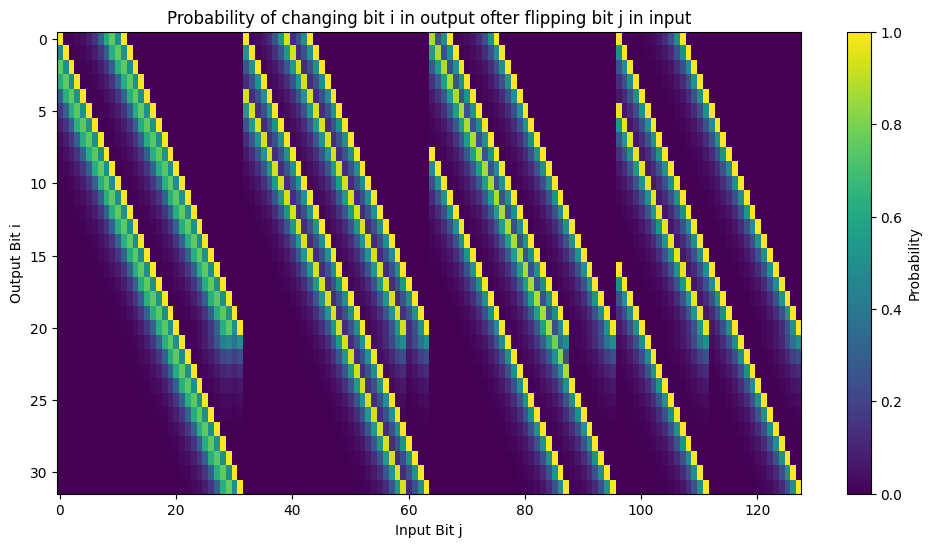

In [18]:
def original(a, b, c, d):
    h = a * 5 + b * 17 + c * 257 + d * 65537
    h += h >> 11
    return h & 0xFFFFFFFF


draw_heatmap(original)

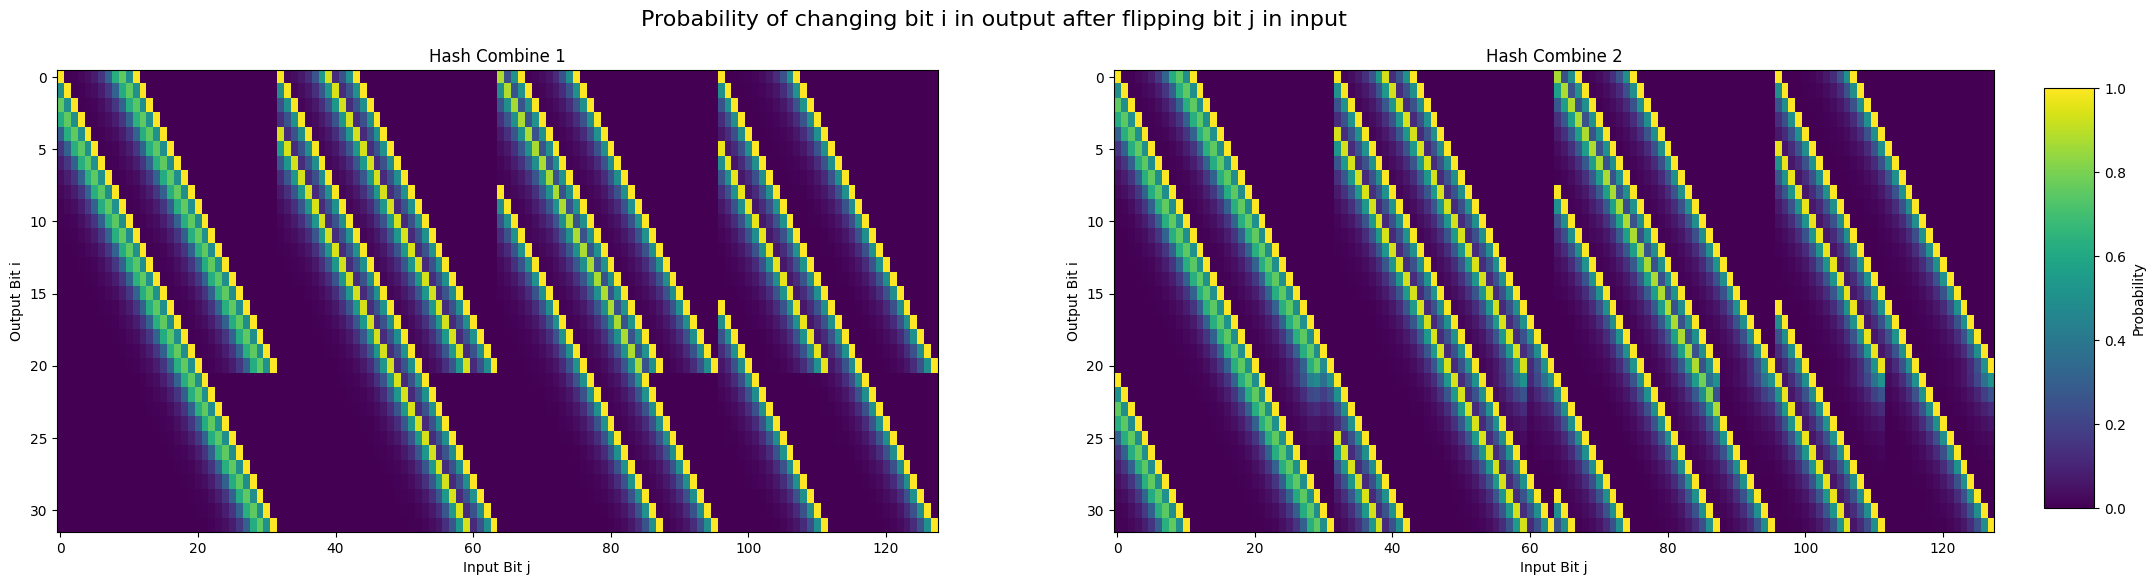

In [24]:
def murmur(a, b, c, d):
    h = 0
    h ^= a + 0x9E3779B9 + (h << 6) + (h >> 2)
    h ^= b + 0x9E3779B9 + (h << 6) + (h >> 2)
    h ^= c + 0x9E3779B9 + (h << 6) + (h >> 2)
    h ^= d + 0x9E3779B9 + (h << 6) + (h >> 2)
    return h & 0xFFFFFFFF

def orig_rot(a, b, c, d):
    h = a * 5 + b * 17 + c * 257 + d * 65537
    h += ror32(h, 11)
    return h & 0xFFFFFFFF

import zlib

def modif(a, b, c, d):
    h = a * 5 + b * 17 + c * 257 + d * 65537
    h ^= h >> 11
    # h += ror32(h, 11)
    # h = np.array([zlib.crc32(np.uint32(x).tobytes()) for x in h])
    return h & 0xFFFFFFFF

def modif2(a, b, c, d):
    h = a * 5 + b * 17 + c * 257 + d * 65537
    h &= 0xFFFFFFFF
    # h ^= h >> 11
    h += ror32(h, 11)
    # h = np.array([zlib.crc32(np.uint32(x).tobytes()) for x in h])
    return h & 0xFFFFFFFF
draw_heatmap_pair(modif, modif2, num_trials=1e4)